<a href="https://colab.research.google.com/github/kristin-hub/nn/blob/master/segm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os


In [0]:
from os import listdir, rename
from os.path import isfile, join


train_dir = os.path.join('//content/drive/My Drive/data/seg/foto2')
mask_dir = os.path.join('/content/drive/My Drive/data/seg/mmm2')


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD

from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [0]:
def image_generator(files, batch_size = 5, sz = (256, 256)):
  
  while True: 
    
    batch = np.random.choice(files, size = batch_size)    
    
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        mask = Image.open(f'/content/drive/My Drive/data/seg/mmm2/{f[:-4]}.png')
        mask = np.array(mask.resize(sz), dtype=np.float32)

        mask[mask >= 0.5] = 1
        mask[mask < 0.5 ] = 0
        
        batch_y.append(mask)

        raw = Image.open(f'/content/drive/My Drive/data/seg/foto2/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #если изображение ч/б
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)
        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)


    batch_x = np.array(batch_x, dtype=np.float32)/255.
    batch_y = np.array(batch_y, dtype=np.float32)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 5

all_files = os.listdir(train_dir)
shuffle(all_files)

split = int(0.7 * len(all_files))

train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

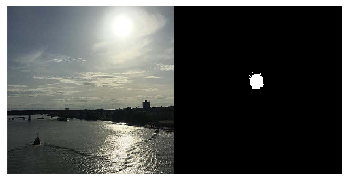

In [8]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk], axis = 1))

Использовала различные метрики

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [0]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz, dtype='float32')
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [iou_coef])
  
  return model

In [0]:
model = unet()

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks


class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('iou_coef'))
        self.val_acc.append(logs.get('val_iou_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'iou_coef=',logs.get('iou_coef'),'val_iou_coef=',logs.get('val_iou_coef'))


        path = np.random.choice(test_files)
        raw = Image.open(f'/content/drive/My Drive/data/seg/foto2/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        pred = model.predict(np.expand_dims(raw, 0))
        
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.1] = 1
        msk[msk < 0.1] = 0
        
        combined = np.concatenate([raw, msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

i= 1 loss= 0.1618216150395927 val_loss= 0.05920795082218117 iou_coef= 0.006368913413358054 val_iou_coef= 0.004944111962147333


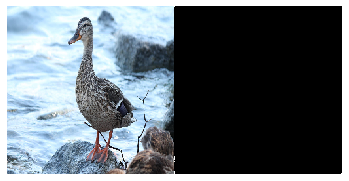

i= 2 loss= 0.06269157666062551 val_loss= 0.06066398174260502 iou_coef= 0.0051354279608598775 val_iou_coef= 0.005366553121280891


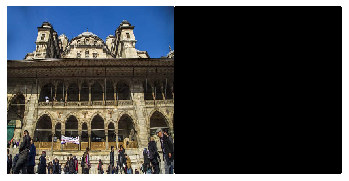

i= 3 loss= 0.06057423736072249 val_loss= 0.05651934817433357 iou_coef= 0.005496031621338001 val_iou_coef= 0.005626260803115589


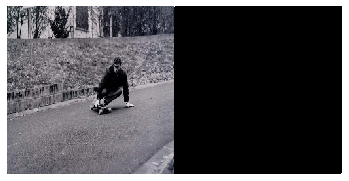

i= 4 loss= 0.05709835413902525 val_loss= 0.060174002691551494 iou_coef= 0.005566246822358124 val_iou_coef= 0.004990616291588931


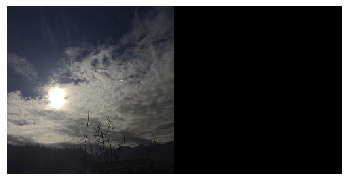

i= 5 loss= 0.05856389370525167 val_loss= 0.05945053013662497 iou_coef= 0.005735886410721356 val_iou_coef= 0.005565673311206477


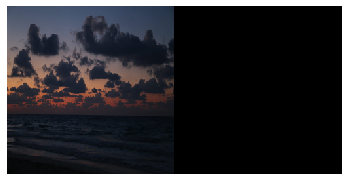

i= 6 loss= 0.05774424523706474 val_loss= 0.05845307355263719 iou_coef= 0.005675564693760068 val_iou_coef= 0.0054529535722125455


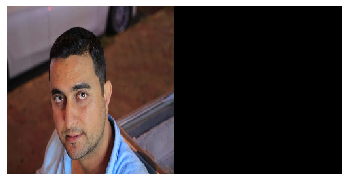

i= 7 loss= 0.0580011670374208 val_loss= 0.058822758599287935 iou_coef= 0.005704875906101531 val_iou_coef= 0.0054578409116301276


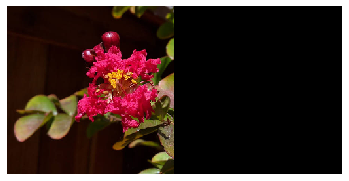

i= 8 loss= 0.05710328976431536 val_loss= 0.058054123694698014 iou_coef= 0.005706117436703708 val_iou_coef= 0.005548868824175939


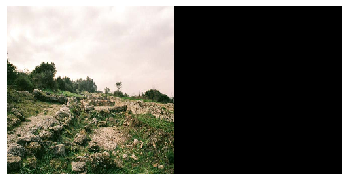

i= 9 loss= 0.06180026875956664 val_loss= 0.06251508804659049 iou_coef= 0.0060589448955383094 val_iou_coef= 0.005598064568066211


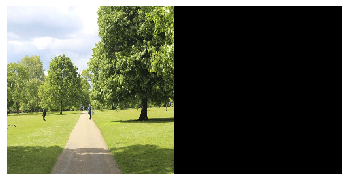

i= 10 loss= 0.05910038979103168 val_loss= 0.059623396679483076 iou_coef= 0.006350998173556512 val_iou_coef= 0.007013523660134524


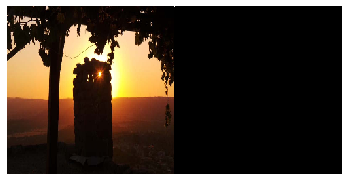

i= 11 loss= 0.06016281550188386 val_loss= 0.057687289736889025 iou_coef= 0.007080415871718692 val_iou_coef= 0.007085997162869683


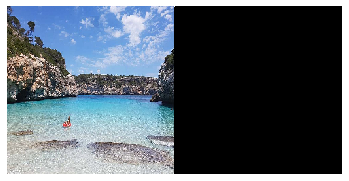

i= 12 loss= 0.056145168574793 val_loss= 0.0525851370939226 iou_coef= 0.0076526001997528565 val_iou_coef= 0.007490271728278862


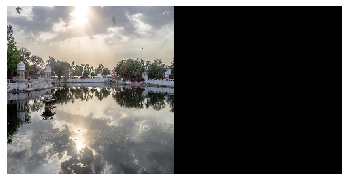

i= 13 loss= 0.056065346203034834 val_loss= 0.048826890273226634 iou_coef= 0.007652216616811024 val_iou_coef= 0.006869402088880263


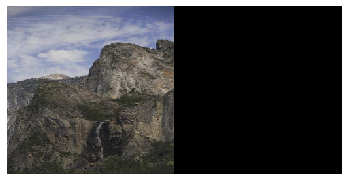

i= 14 loss= 0.054976767845570096 val_loss= 0.05165630720417808 iou_coef= 0.007790525563962994 val_iou_coef= 0.007542735491706817


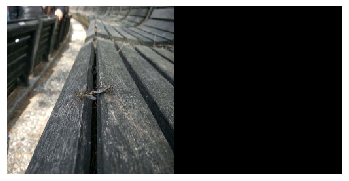

i= 15 loss= 0.05786337625117056 val_loss= 0.05086587545358472 iou_coef= 0.009033911024397682 val_iou_coef= 0.008125082210258202


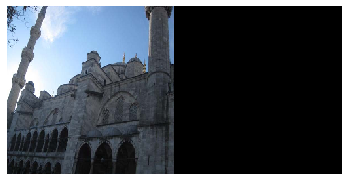

In [24]:
model.fit_generator(train_generator, 
                    epochs = 15, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)